In [5]:
# ===========================================================
#  library
# ===========================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [6]:
# ===========================================================
#  CFG
# ===========================================================
class CFG:
    seed = 42
    n_splits = 5
    data_dir = "G:/マイドライブ/signate_MUFJ2023/data/"
    num_boost_round = 10000
    stopping_rounds = 1500
    save_dir = "G:/マイドライブ/signate_MUFJ2023/exp/"

In [7]:
# ===========================================================
#  Utils
# ===========================================================
def get_score(y_true, y_pred):
    """
    評価関数の入力となる検証用データ、及び学習に使用する学習用データの目的変数について、
    1: 不正利用あり, 0: 不正利用なしとします。
    """
    return f1_score(y_true, y_pred)

## train & test

| カラム | ヘッダ名称      | データ型   | 説明                                |
|-------|--------------|----------|------------------------------------|
| 0     | index        | int      | インデックス                          |
| 1     | user_id      | int      | ユーザーのID番号                      |
| 2     | card_id      | int      | 各ユーザーが保有しているカードの識別用ID |
| 3     | amount       | varchar  | カード取引額                         |
| 4     | errors?      | varchar  | 取引が成立したかどうか                 |
| 5     | is_fraud?    | int      | 不正利用の有無（不正利用あり=1, 不正利用なし=0） |
| 6     | merchant_id  | int      | 利用店舗ID                          |
| 7     | merchant_city| varchar  | 利用店舗所在市町村                     |
| 8     | merchant_state | char    | 利用店舗所在州                       |
| 9     | zip          | float    | 利用店舗郵便番号                      |
| 10    | mcc          | int      | 加盟店業種コード                      |
| 11    | use_chip     | varchar  | カード取引方法                        |


In [8]:
train = pd.read_csv(CFG.data_dir+"train.csv")
print(train.shape)
print(train.info())
train.head()

(471283, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471283 entries, 0 to 471282
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   index           471283 non-null  int64  
 1   user_id         471283 non-null  int64  
 2   card_id         471283 non-null  int64  
 3   amount          471283 non-null  object 
 4   errors?         471283 non-null  object 
 5   is_fraud?       471283 non-null  int64  
 6   merchant_id     471283 non-null  int64  
 7   merchant_city   471283 non-null  object 
 8   merchant_state  400595 non-null  object 
 9   zip             392063 non-null  float64
 10  mcc             471283 non-null  int64  
 11  use_chip        471283 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 43.1+ MB
None


,index,user_id,card_id,amount,errors?,is_fraud?,merchant_id,merchant_city,merchant_state,zip,mcc,use_chip
0,0,1721,0,$2.623,OK,0,209237,Joliet,IL,60436.0,5541,Swipe Transaction
1,1,1629,3,$6.4,OK,0,2568,Edgerton,WI,53534.0,5814,Swipe Transaction
2,2,655,3,$123.5,OK,0,345310,Ridgefield,WA,98642.0,7538,Swipe Transaction
3,3,492,0,$51.287,OK,0,4295,Milton,FL,32583.0,5912,Chip Transaction
4,4,1969,4,$17.561,OK,0,350447,Irvington,NJ,7111.0,4214,Swipe Transaction


In [9]:
# amount
train["amount"] = train["amount"].apply(lambda x:x[1:]).astype(float)

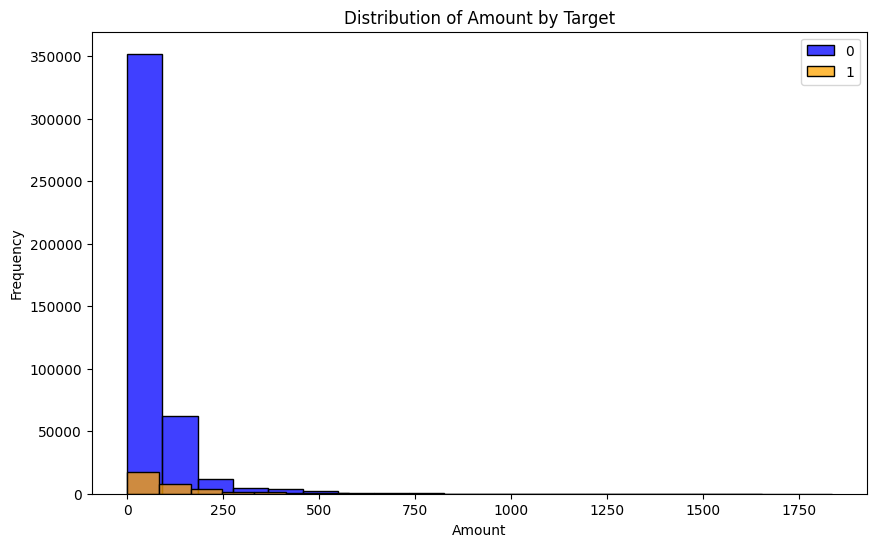

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(train[train['is_fraud?'] == 0]['amount'], bins=20, color='blue', label='0')
sns.histplot(train[train['is_fraud?'] == 1]['amount'], bins=20, color='orange', label='1')
plt.title('Distribution of Amount by Target')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [11]:
train[train["is_fraud?"] == 1]["amount"].describe(), train[train["is_fraud?"] == 0]["amount"].describe(), 

(count    32631.000000
 mean       116.459783
 std        130.895622
 min          0.010000
 25%         28.000000
 50%         76.700000
 75%        154.000000
 max       1651.552000
 Name: amount, dtype: float64,
 count    438652.000000
 mean         63.195395
 std          85.488668
 min           0.001000
 25%          14.780000
 50%          40.000000
 75%          80.000000
 max        1833.825000
 Name: amount, dtype: float64)

In [12]:
train.describe()

,index,user_id,card_id,amount,is_fraud?,merchant_id,zip,mcc
count,471283.000000,471283.000000,471283.000000,471283.000000,471283.000000,471283.000000,392063.000000,471283.000000
mean,235641.000000,1054.456562,1.735567,66.883350,0.069239,208349.620071,52575.379857,5582.452335
std,136047.827795,547.842878,1.655869,90.395838,0.253860,117299.644100,27653.240548,1038.271616
min,0.000000,39.000000,0.000000,0.001000,0.000000,58.000000,1012.000000,1711.000000
25%,117820.500000,655.000000,0.000000,15.208000,0.000000,109014.000000,30752.000000,5300.000000
50%,235641.000000,1033.000000,1.000000,41.920000,0.000000,214279.000000,48357.000000,5499.000000
75%,353461.500000,1571.000000,3.000000,83.193500,0.000000,311083.000000,76384.000000,5814.000000
max,471282.000000,1986.000000,8.000000,1833.825000,1.000000,407238.000000,99829.000000,9402.000000


In [13]:
len(train["merchant_id"].unique())

25076

In [14]:
test = pd.read_csv(CFG.data_dir+"test.csv")
print(test.shape)
print(test.info())
test.head()

(457958, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457958 entries, 0 to 457957
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   index           457958 non-null  int64  
 1   user_id         457958 non-null  int64  
 2   card_id         457958 non-null  int64  
 3   amount          457958 non-null  object 
 4   errors?         457958 non-null  object 
 5   merchant_id     457958 non-null  int64  
 6   merchant_city   457958 non-null  object 
 7   merchant_state  388444 non-null  object 
 8   zip             380060 non-null  float64
 9   mcc             457958 non-null  int64  
 10  use_chip        457958 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 38.4+ MB
None


,index,user_id,card_id,amount,errors?,merchant_id,merchant_city,merchant_state,zip,mcc,use_chip
0,471283,541,3,$113.278,OK,324189,Orlando,FL,32821.0,4814,Swipe Transaction
1,471284,655,1,$293.944,OK,81219,Ridgefield,WA,98642.0,7538,Chip Transaction
2,471285,492,0,$47.4,OK,274755,Arlington Heights,IL,60004.0,5719,Swipe Transaction
3,471286,236,1,$167.0,OK,255962,Berkeley,CA,94702.0,5300,Swipe Transaction
4,471287,882,2,$126.619,ERROR,271748,Rochester,MN,55901.0,4829,Swipe Transaction


In [15]:
# amount
test["amount"] = test["amount"].apply(lambda x:x[1:]).astype(float)

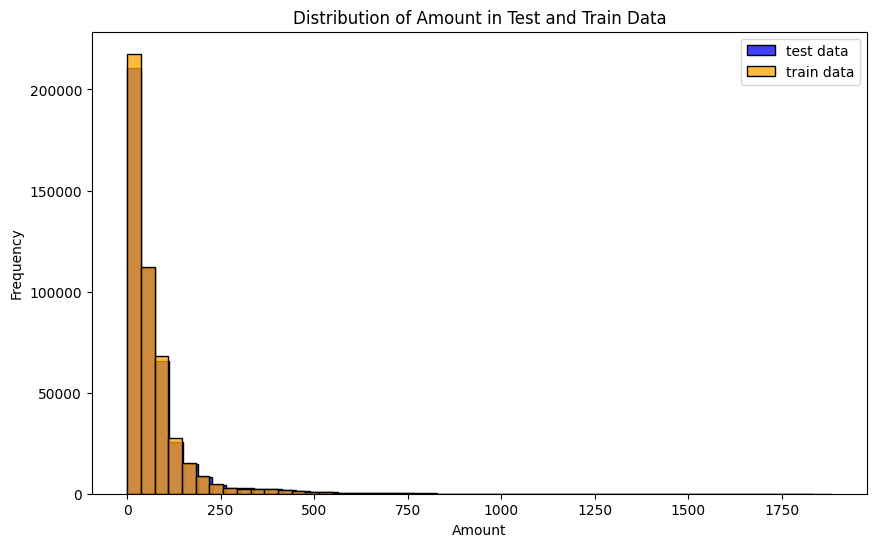

In [16]:
plt.figure(figsize=(10, 6))
sns.histplot(test["amount"], bins=50, color='blue', label='test data')
sns.histplot(train["amount"], bins=50, color='orange', label='train data')
plt.title('Distribution of Amount in Test and Train Data')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Card

| カラム                | ヘッダ名称           | データ型   | 説明                           |
|----------------------|-------------------|----------|-------------------------------|
| 0                    | user_id           | int      | ユーザーのID番号                |
| 1                    | card_id           | int      | 各ユーザーが保有しているカードの識別用ID |
| 2                    | card_brand        | varchar  | カードのブランド                |
| 3                    | card_type         | varchar  | カードタイプ                    |
| 4                    | expires           | varchar  | 有効期限                        |
| 5                    | has_chip          | varchar  | Chipがあるかどうか               |
| 6                    | cards_issued      | int      | アカウントに紐づくカードの発行枚数 |
| 7                    | credit_limit      | varchar  | 利用可能額上限                  |
| 8                    | acct_open_date    | varchar  | アカウント作成日                |
| 9                    | year_pin_last_changed | int  | pinコードを最後に変更した日     |


In [17]:
card = pd.read_csv(CFG.data_dir+"card.csv")
print(card.shape)
print(card.info())
card.head()

(416, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   user_id                416 non-null    int64 
 1   card_id                416 non-null    int64 
 2   card_brand             416 non-null    object
 3   card_type              416 non-null    object
 4   expires                416 non-null    object
 5   has_chip               416 non-null    object
 6   cards_issued           416 non-null    int64 
 7   credit_limit           416 non-null    object
 8   acct_open_date         416 non-null    object
 9   year_pin_last_changed  416 non-null    int64 
dtypes: int64(4), object(6)
memory usage: 32.6+ KB
None


,user_id,card_id,card_brand,card_type,expires,has_chip,cards_issued,credit_limit,acct_open_date,year_pin_last_changed
0,39,0,Visa,Debit,09/2021,YES,1,$17117,05/2007,2010
1,39,1,Amex,Credit,11/2024,YES,2,$5400,10/2015,2015
2,41,0,Discover,Credit,03/2022,YES,2,$14800,12/2010,2011
3,41,1,Mastercard,Debit,09/2024,YES,2,$4183,09/2010,2010
4,41,2,Mastercard,Debit,03/2024,YES,1,$6732,02/2010,2010


## user

| カラム                      | ヘッダ名称                     | データ型   | 説明                                    |
|---------------------------|-----------------------------|----------|----------------------------------------|
| 0                         | user_id                     | int      | ユーザーのID番号                         |
| 1                         | current_age                 | int      | 年齢                                   |
| 2                         | retirement_age              | int      | 退職年齢                               |
| 3                         | birth_year                  | int      | 誕生年                                  |
| 4                         | birth_month                 | int      | 誕生月                                  |
| 5                         | gender                      | varchar  | 性別                                    |
| 6                         | address                     | varchar  | 住所詳細                                |
| 7                         | city                        | varchar  | 市町村                                  |
| 8                         | state                       | varchar  | 州                                      |
| 9                         | zipcode                     | int      | 郵便番号                                |
| 10                        | latitude                    | float    | 住所の緯度                              |
| 11                        | longitude                   | float    | 住所の経度                              |
| 12                        | per_capita_income_zipcode   | varchar  | 郵便番号区切りの地域ごとの平均年収       |
| 13                        | yearly_income_person        | varchar  | 年収                                    |
| 14                        | total_debt                  | varchar  | ローン総額                              |
| 15                        | fico_score                  | int      | クレジットスコア                        |
| 16                        | num_credit_cards            | int      | 所有するクレジットカード枚数            |


In [18]:
user = pd.read_csv(CFG.data_dir+"user.csv")
print(user.shape)
print(user.info())
user.head()

(97, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    97 non-null     int64  
 1   current_age                97 non-null     int64  
 2   retirement_age             97 non-null     int64  
 3   birth_year                 97 non-null     int64  
 4   birth_month                97 non-null     int64  
 5   gender                     97 non-null     object 
 6   address                    97 non-null     object 
 7   city                       97 non-null     object 
 8   state                      97 non-null     object 
 9   zipcode                    97 non-null     int64  
 10  latitude                   97 non-null     float64
 11  longitude                  97 non-null     float64
 12  per_capita_income_zipcode  97 non-null     object 
 13  yearly_income_person       97 non-null     

,user_id,current_age,retirement_age,birth_year,birth_month,gender,address,city,state,zipcode,latitude,longitude,per_capita_income_zipcode,yearly_income_person,total_debt,fico_score,num_credit_cards
0,39,57,64,1962,12,Female,442 Burns Boulevard,Mansfield,MA,2048,42.02,-71.21,$37407,$76274,$102611,698,2
1,41,39,66,1980,10,Female,3863 River Avenue,Lincoln,CA,95648,38.93,-121.25,$21829,$44506,$57994,849,3
2,47,40,67,1979,5,Female,8799 Elm Avenue,Mckinney,TX,75069,33.20,-96.65,$24684,$50329,$76759,625,4
3,54,59,67,1960,3,Male,1362 Norfolk Drive,Montgomery,AL,36111,32.35,-86.28,$21102,$43021,$86014,725,4
4,80,66,59,1954,1,Female,1105 Second Drive,Dearborn,MI,48124,42.31,-83.21,$24561,$48690,$36262,701,6


## Compare 

In [19]:
# ===============================================================
#  Data Loading
# ===============================================================
train = pd.read_csv(CFG.data_dir+"train.csv")
test = pd.read_csv(CFG.data_dir+"test.csv")
card = pd.read_csv(CFG.data_dir+"card.csv")
user = pd.read_csv(CFG.data_dir+"user.csv")

train["flag"] = "train"
test["flag"] = "test"
all_data = pd.concat([train, test], ignore_index=True)
all_data = pd.merge(all_data, card, on=["user_id", "card_id"], how="left")
all_data = pd.merge(all_data, user, on="user_id", how="left")

In [20]:
# ===============================================================
#  Preprocessing
# ===============================================================
# common part
## amount
all_data["amount"] = all_data["amount"].apply(lambda x:x[1:]).astype(float)


all_data['credit_limit'] = all_data['credit_limit'].apply(lambda x:x[1:]).astype(float)

## per_capita_income_zipcode	
all_data["per_capita_income_zipcode"] = all_data["per_capita_income_zipcode"].apply(lambda x:x[1:]).astype(float)

## yearly_income_person	
all_data["yearly_income_person"] = all_data["yearly_income_person"].apply(lambda x:x[1:]).astype(float)

## total_debt
all_data["total_debt"] = all_data["total_debt"].apply(lambda x:x[1:]).astype(float)

## expires
all_data[["expires_1", "expires_2"]] = all_data["expires"].str.split("/", expand=True).astype(int)

all_data[["acct_open_date_1", "acct_open_date_2"]] = all_data["acct_open_date"].str.split("/", expand=True).astype(int)


train = all_data[all_data["flag"] == "train"].reset_index(drop=True)
test = all_data[all_data["flag"] == "test"].reset_index(drop=True)

In [21]:
all_data.columns

Index(['index', 'user_id', 'card_id', 'amount', 'errors?', 'is_fraud?',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'use_chip', 'flag', 'card_brand', 'card_type', 'expires', 'has_chip',
       'cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'current_age', 'retirement_age', 'birth_year',
       'birth_month', 'gender', 'address', 'city', 'state', 'zipcode',
       'latitude', 'longitude', 'per_capita_income_zipcode',
       'yearly_income_person', 'total_debt', 'fico_score', 'num_credit_cards',
       'expires_1', 'expires_2', 'acct_open_date_1', 'acct_open_date_2'],
      dtype='object')

### amount

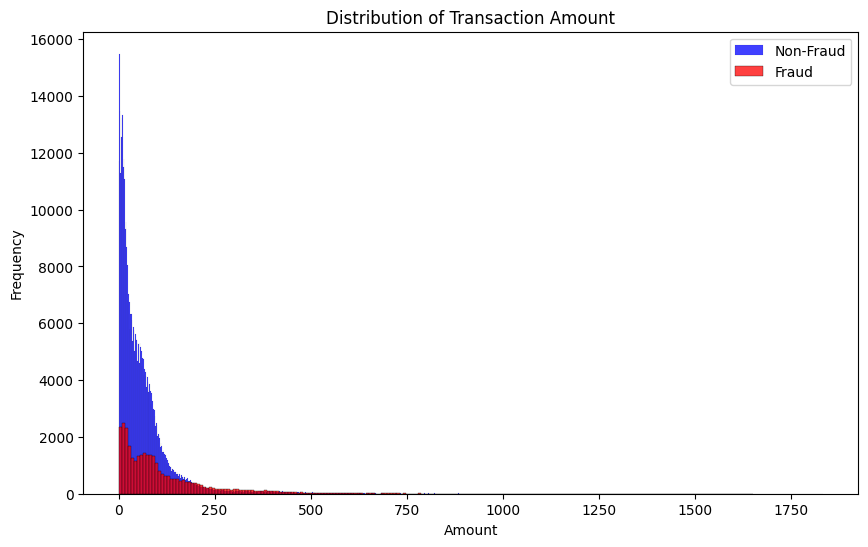

In [22]:
# グラフを作成
plt.figure(figsize=(10, 6))  # グラフのサイズを設定

# ヒストグラムを重ねてプロット
sns.histplot(data=train[train["is_fraud?"] == 0], x="amount", color="blue", label="Non-Fraud")
sns.histplot(data=train[train["is_fraud?"] == 1], x="amount", color="red", label="Fraud")


# グラフにタイトルとラベルを追加
plt.title("Distribution of Transaction Amount")
plt.xlabel("Amount")
plt.ylabel("Frequency")

# 凡例を表示
plt.legend()

# グラフを表示
plt.show()

In [23]:
import numpy as np
train["amount_map"], bins = pd.cut(x=train["amount"], bins=int(1+np.log(2*len(train))*10), labels=False, retbins=True)

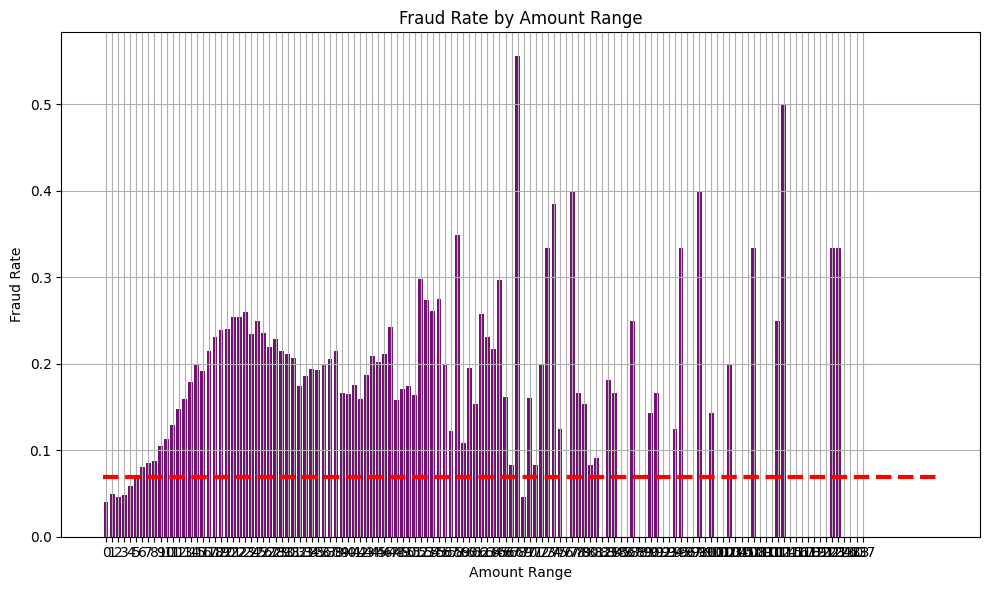

In [24]:
# "amount_map"ごとの詐欺率を計算
fraud_rate_by_amount = train.groupby("amount_map")["is_fraud?"].mean()

# グラフを作成
plt.figure(figsize=(10, 6))  # グラフのサイズを設定

# 詐欺率をプロット
sns.barplot(x=fraud_rate_by_amount.index, y=fraud_rate_by_amount.values, color="purple")

# グラフにタイトルとラベルを追加
plt.title("Fraud Rate by Amount Range")
plt.xlabel("Amount Range")
plt.ylabel("Fraud Rate")

plt.hlines(train["is_fraud?"].mean(), fraud_rate_by_amount.index.min()-0.5, fraud_rate_by_amount.index.max()+0.5, colors='red', linestyle='dashed', linewidth=3)

# グラフを表示
#plt.xticks(rotation=45)  # x軸ラベルを回転して読みやすくする
plt.tight_layout()  # レイアウト調整
plt.grid()
plt.show()

### errors?

In [25]:
train["errors?"].value_counts()

errors?
OK       405884
ERROR     65399
Name: count, dtype: int64

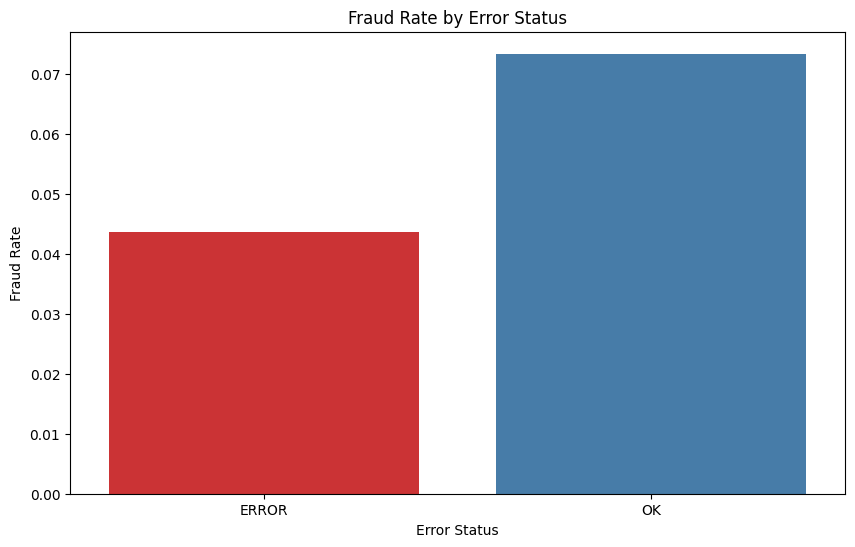

In [26]:
# グラフを作成
plt.figure(figsize=(10, 6))  # グラフのサイズを設定

# "error?"ごとに詐欺の割合を計算
fraud_rate_by_error = train.groupby("errors?")["is_fraud?"].mean()

# 棒グラフを作成
sns.barplot(x=fraud_rate_by_error.index, y=fraud_rate_by_error.values, palette="Set1")

# グラフにタイトルとラベルを追加
plt.title("Fraud Rate by Error Status")
plt.xlabel("Error Status")
plt.ylabel("Fraud Rate")

# グラフを表示
plt.show()


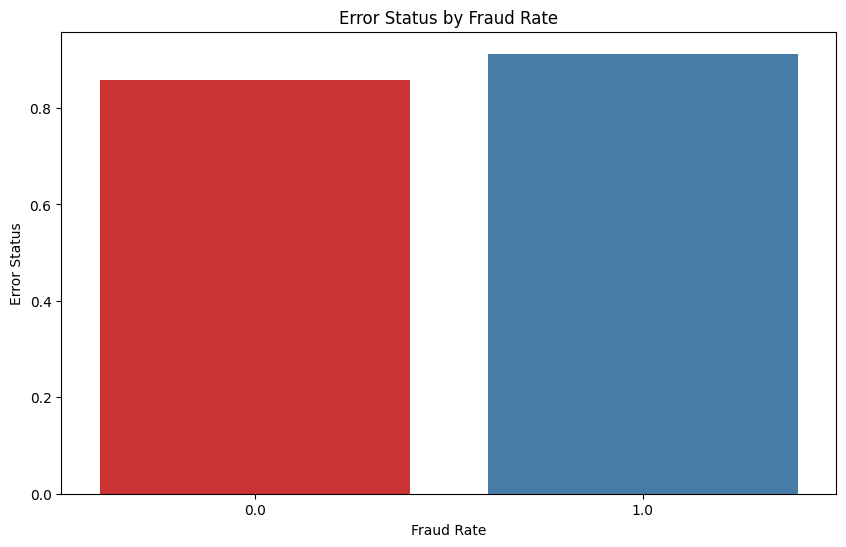

In [27]:
# グラフを作成
plt.figure(figsize=(10, 6))  # グラフのサイズを設定

# "error?"ごとに詐欺の割合を計算
train["errors_map"] = train["errors?"].map(
    {"OK":1,
     "ERROR":0}
)
fraud_rate_by_error = train.groupby("is_fraud?")["errors_map"].mean()

# 棒グラフを作成
sns.barplot(x=fraud_rate_by_error.index, y=fraud_rate_by_error.values, palette="Set1")

# グラフにタイトルとラベルを追加
plt.title("Error Status by Fraud Rate")
plt.ylabel("Error Status")
plt.xlabel("Fraud Rate")

# グラフを表示
plt.show()

### merchant_id

In [28]:
train.groupby('merchant_id')["is_fraud?"].mean().sort_values()

merchant_id
58        0.0
252636    0.0
252624    0.0
252567    0.0
252490    0.0
         ... 
313089    1.0
45317     1.0
338922    1.0
183962    1.0
189283    1.0
Name: is_fraud?, Length: 25076, dtype: float64

## merchant_city

In [29]:
len(train["merchant_id"].unique())

25076

In [30]:
len(train["merchant_city"].unique())

4396

In [31]:
len(train["state"].unique())

37

### state

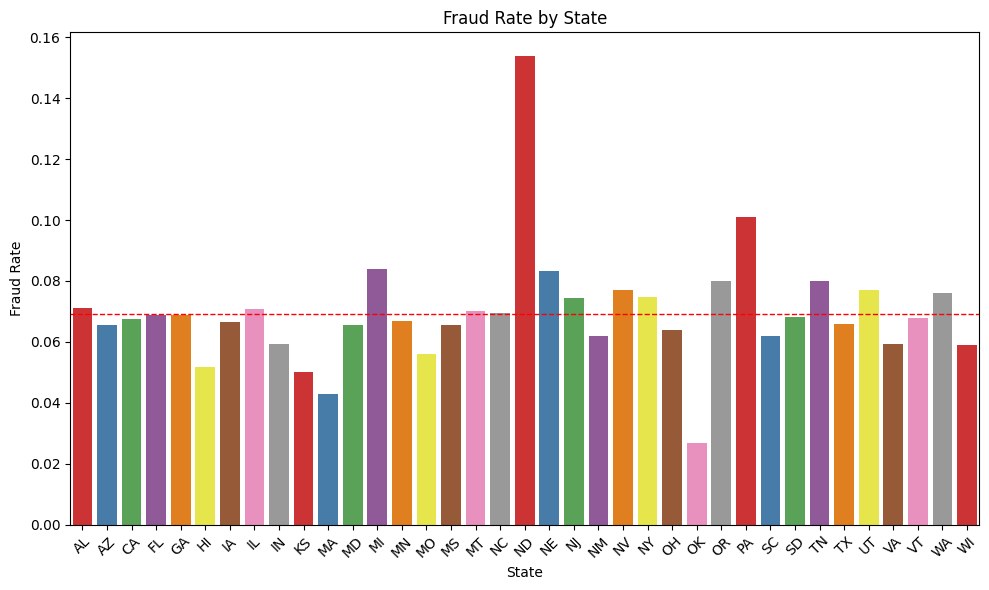

In [32]:
# Calculate the fraud rate by state
fraud_rate_by_state = train.groupby("state")["is_fraud?"].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_rate_by_state.index, y=fraud_rate_by_state.values, palette="Set1")

# Add a dashed red line indicating the overall fraud rate
plt.axhline(y=train["is_fraud?"].mean(), color='red', linestyle='dashed', linewidth=1)

# Set the title and labels
plt.title("Fraud Rate by State")
plt.xlabel("State")
plt.ylabel("Fraud Rate")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

### mcc

In [33]:
len(train["mcc"].unique())

109

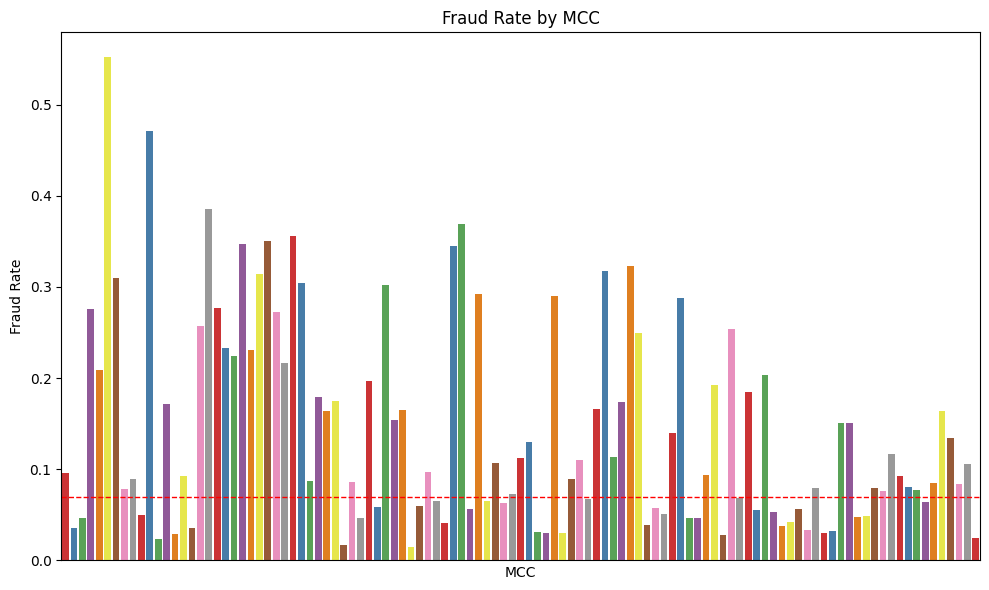

In [34]:
# Calculate the fraud rate by mcc
fraud_rate_by_mcc = train.groupby("mcc")["is_fraud?"].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_rate_by_mcc.index, y=fraud_rate_by_mcc.values, palette="Set1")

# Add a dashed red line indicating the overall fraud rate
plt.axhline(y=train["is_fraud?"].mean(), color='red', linestyle='dashed', linewidth=1)

# Set the title and labels
plt.title("Fraud Rate by MCC")
plt.xlabel("MCC")
plt.ylabel("Fraud Rate")

# Remove x-axis ticks
plt.xticks([])

# Show the plot
plt.tight_layout()
plt.show()

### use_chip

In [35]:
len(train["use_chip"].unique())

3

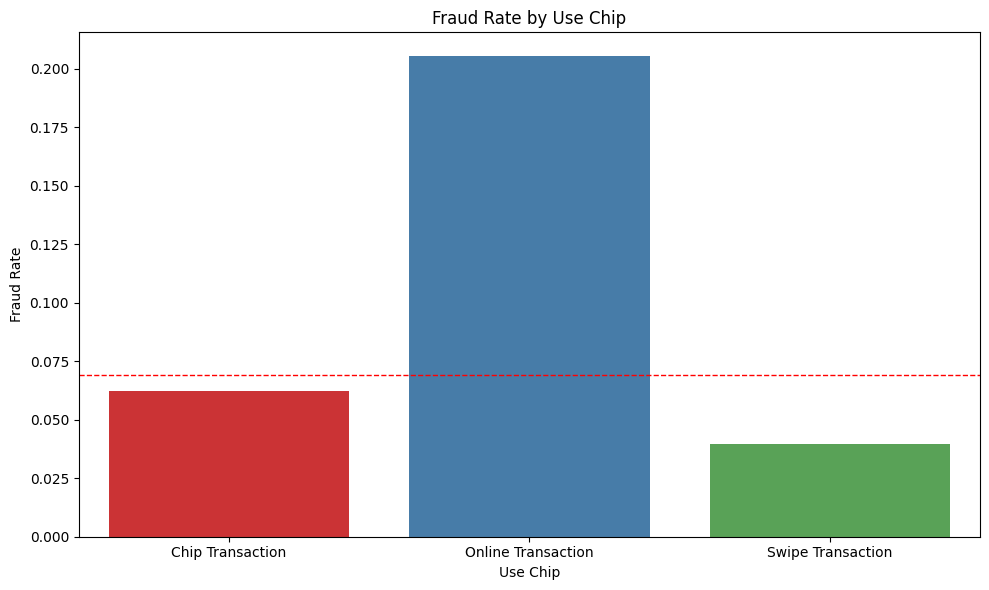

In [36]:
# Calculate the fraud rate by use_chip
fraud_rate_by_chip = train.groupby("use_chip")["is_fraud?"].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_rate_by_chip.index, y=fraud_rate_by_chip.values, palette="Set1")

# Add a dashed red line indicating the overall fraud rate
plt.axhline(y=train["is_fraud?"].mean(), color='red', linestyle='dashed', linewidth=1)

# Set the title and labels
plt.title("Fraud Rate by Use Chip")
plt.xlabel("Use Chip")
plt.ylabel("Fraud Rate")

# Show the plot
plt.tight_layout()
plt.show()

### card_brand

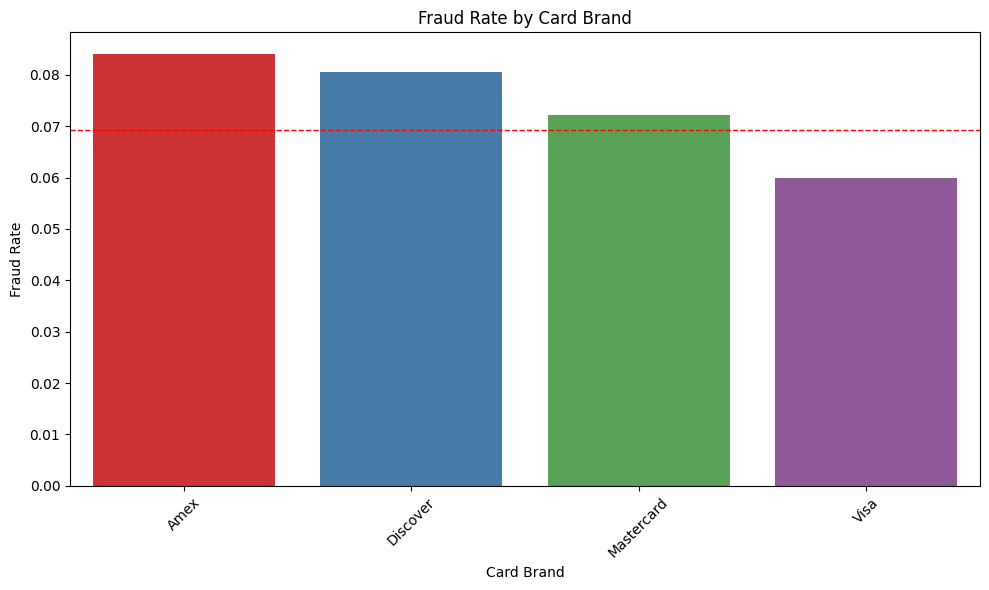

In [37]:
# Calculate the fraud rate by card_brand
fraud_rate_by_brand = train.groupby("card_brand")["is_fraud?"].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_rate_by_brand.index, y=fraud_rate_by_brand.values, palette="Set1")

# Add a dashed red line indicating the overall fraud rate
plt.axhline(y=train["is_fraud?"].mean(), color='red', linestyle='dashed', linewidth=1)

# Set the title and labels
plt.title("Fraud Rate by Card Brand")
plt.xlabel("Card Brand")
plt.ylabel("Fraud Rate")

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

### card_type

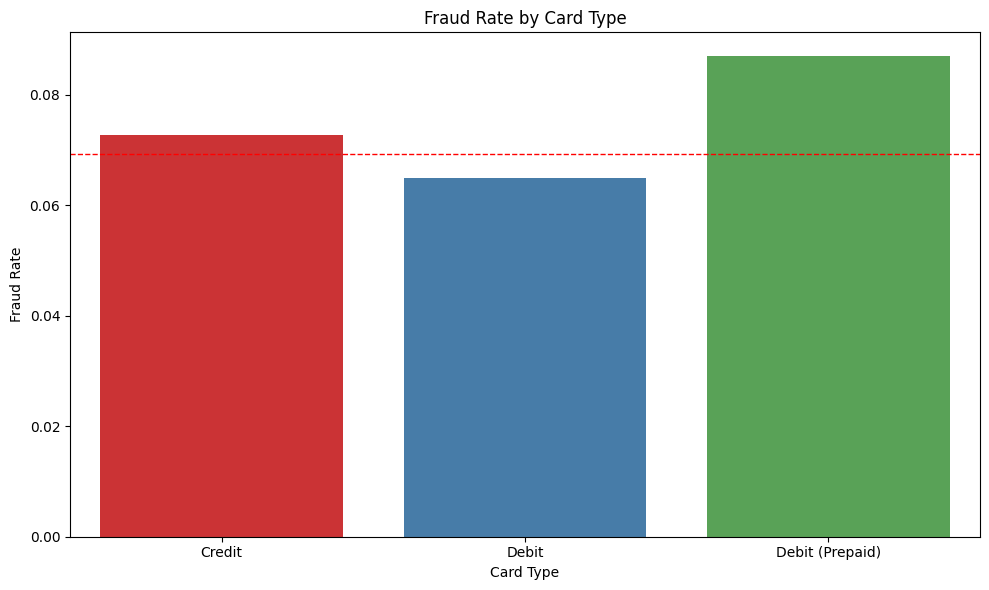

In [38]:
# Calculate the fraud rate by card_type
fraud_rate_by_type = train.groupby("card_type")["is_fraud?"].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_rate_by_type.index, y=fraud_rate_by_type.values, palette="Set1")

# Add a dashed red line indicating the overall fraud rate
plt.axhline(y=train["is_fraud?"].mean(), color='red', linestyle='dashed', linewidth=1)

# Set the title and labels
plt.title("Fraud Rate by Card Type")
plt.xlabel("Card Type")
plt.ylabel("Fraud Rate")

# Show the plot
plt.tight_layout()
plt.show()

### expires

有効期限

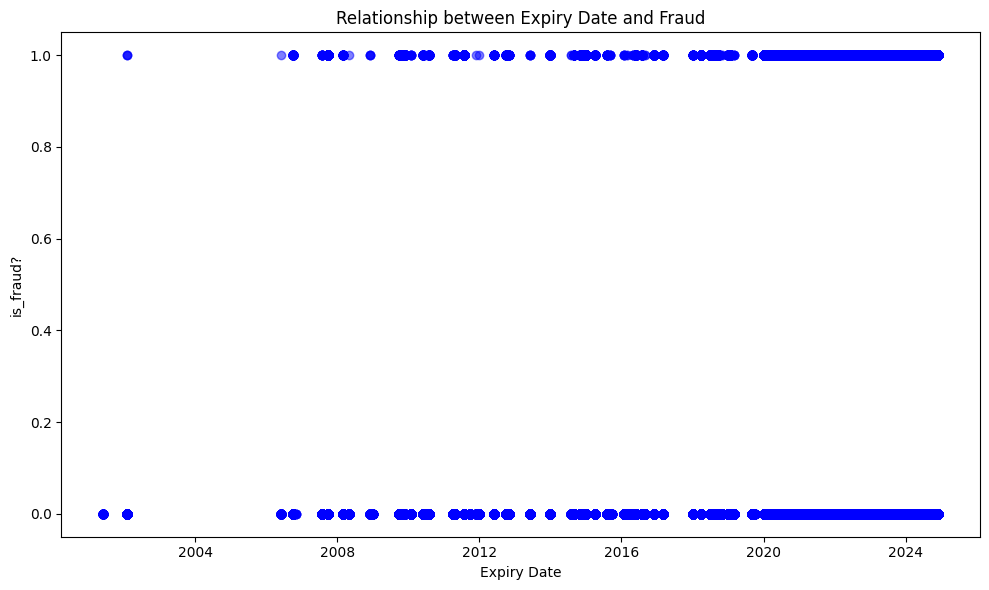

In [39]:
# Assuming train["expires"] is a string in "mm/yyyy" format
train["expires"] = pd.to_datetime(train["expires"], format="%m/%Y")

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(train["expires"], train["is_fraud?"], alpha=0.5, color="blue")

# Set the title and labels
plt.title("Relationship between Expiry Date and Fraud")
plt.xlabel("Expiry Date")
plt.ylabel("is_fraud?")

# Show the plot
plt.tight_layout()
plt.show()

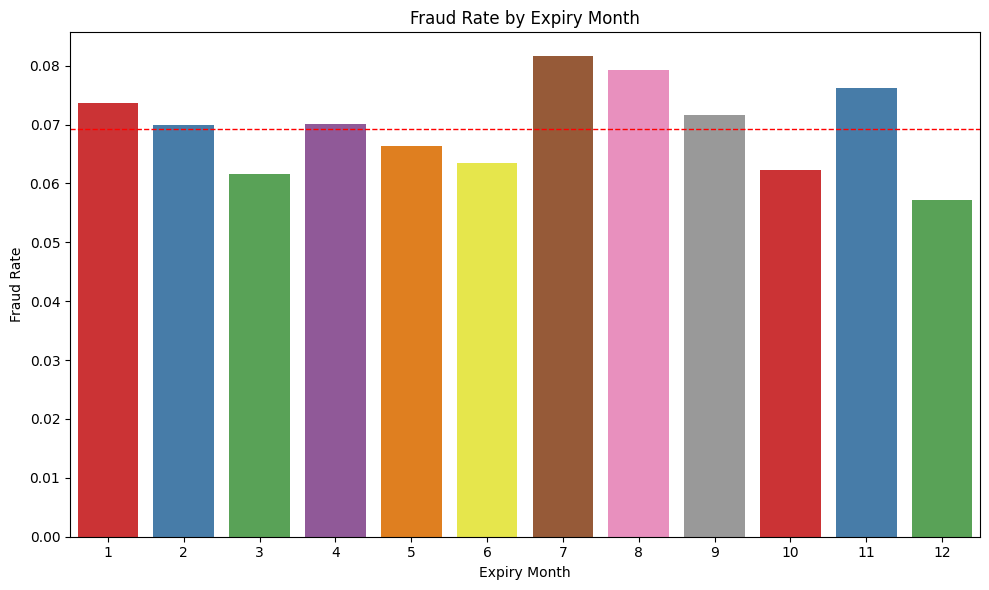

In [40]:
# Calculate the fraud rate by expires_month
fraud_rate_by_month = train.groupby("expires_1")["is_fraud?"].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_rate_by_month.index, y=fraud_rate_by_month.values, palette="Set1")

# Add a dashed red line indicating the overall fraud rate
plt.axhline(y=train["is_fraud?"].mean(), color='red', linestyle='dashed', linewidth=1)

# Set the title and labels
plt.title("Fraud Rate by Expiry Month")
plt.xlabel("Expiry Month")
plt.ylabel("Fraud Rate")

# Show the plot
plt.tight_layout()
plt.show()

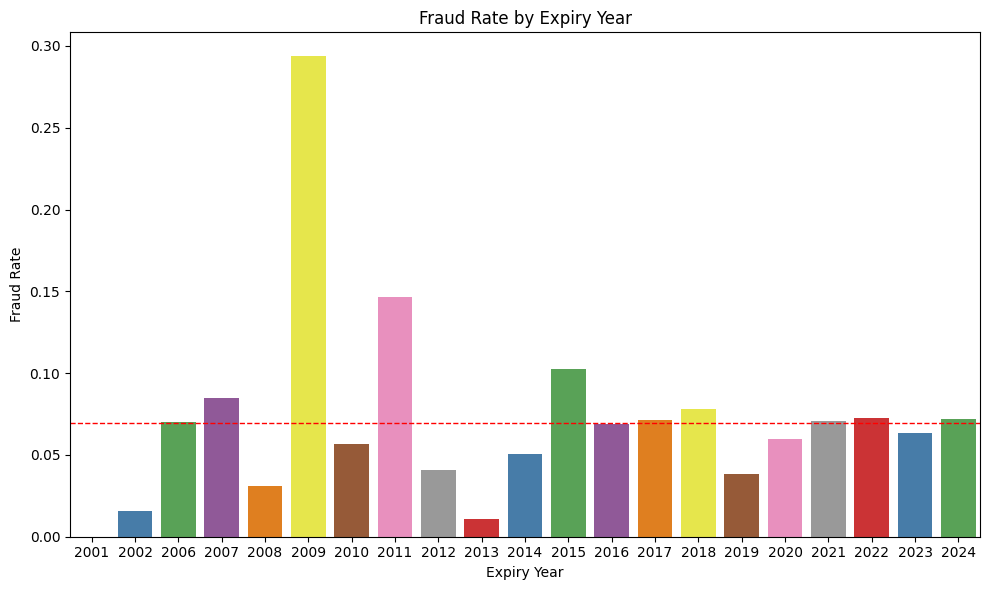

In [41]:
# Calculate the fraud rate by expires_year
fraud_rate_by_year = train.groupby("expires_2")["is_fraud?"].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_rate_by_year.index, y=fraud_rate_by_year.values, palette="Set1")

# Add a dashed red line indicating the overall fraud rate
plt.axhline(y=train["is_fraud?"].mean(), color='red', linestyle='dashed', linewidth=1)

# Set the title and labels
plt.title("Fraud Rate by Expiry Year")
plt.xlabel("Expiry Year")
plt.ylabel("Fraud Rate")

# Show the plot
plt.tight_layout()
plt.show()

In [42]:
len(train[train["expires_2"] == 2009])

1662

TODO: 何故2009年が有効期限のものが狙われているんだ？

### has_chip

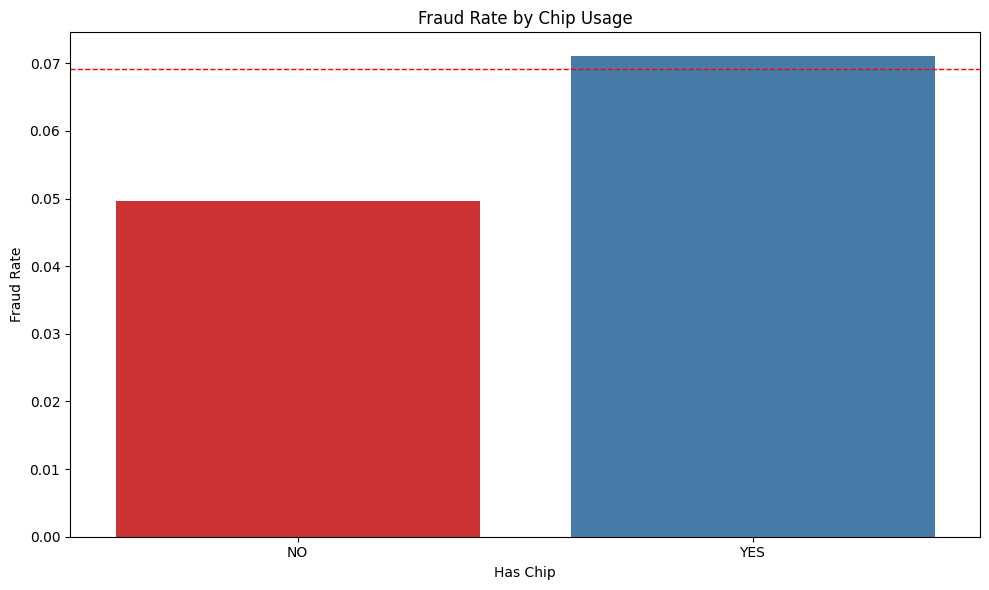

In [43]:
# Calculate the fraud rate by has_chip
fraud_rate_by_chip = train.groupby("has_chip")["is_fraud?"].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_rate_by_chip.index, y=fraud_rate_by_chip.values, palette="Set1")

# Add a dashed red line indicating the overall fraud rate
plt.axhline(y=train["is_fraud?"].mean(), color='red', linestyle='dashed', linewidth=1)

# Set the title and labels
plt.title("Fraud Rate by Chip Usage")
plt.xlabel("Has Chip")
plt.ylabel("Fraud Rate")

# Show the plot
plt.tight_layout()
plt.show()

### cards_issued

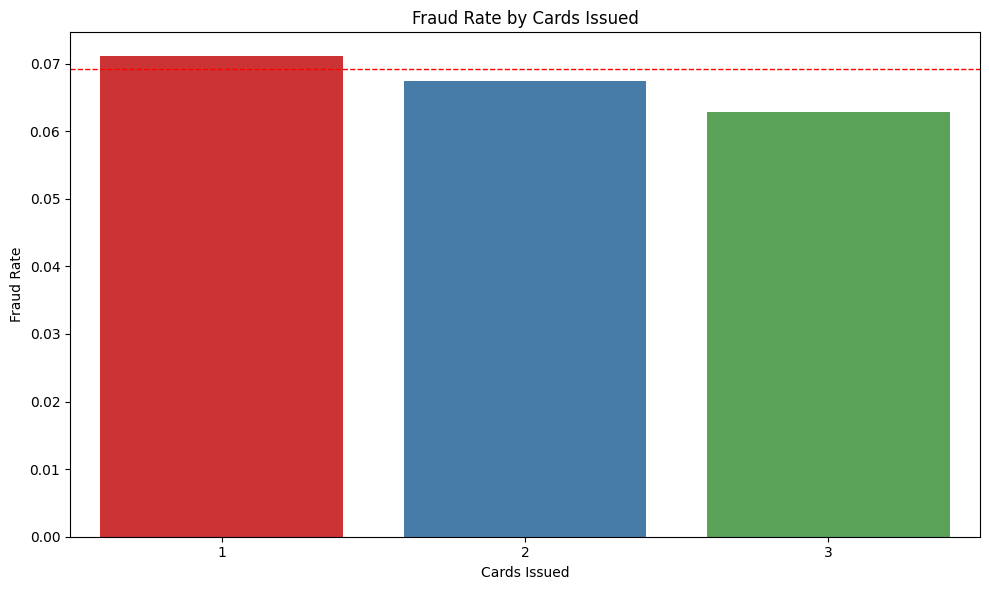

In [44]:
# Calculate the fraud rate by cards_issued
fraud_rate_by_cards = train.groupby("cards_issued")["is_fraud?"].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_rate_by_cards.index, y=fraud_rate_by_cards.values, palette="Set1")

# Add a dashed red line indicating the overall fraud rate
plt.axhline(y=train["is_fraud?"].mean(), color='red', linestyle='dashed', linewidth=1)

# Set the title and labels
plt.title("Fraud Rate by Cards Issued")
plt.xlabel("Cards Issued")
plt.ylabel("Fraud Rate")

# Show the plot
plt.tight_layout()
plt.show()

### credit_limit

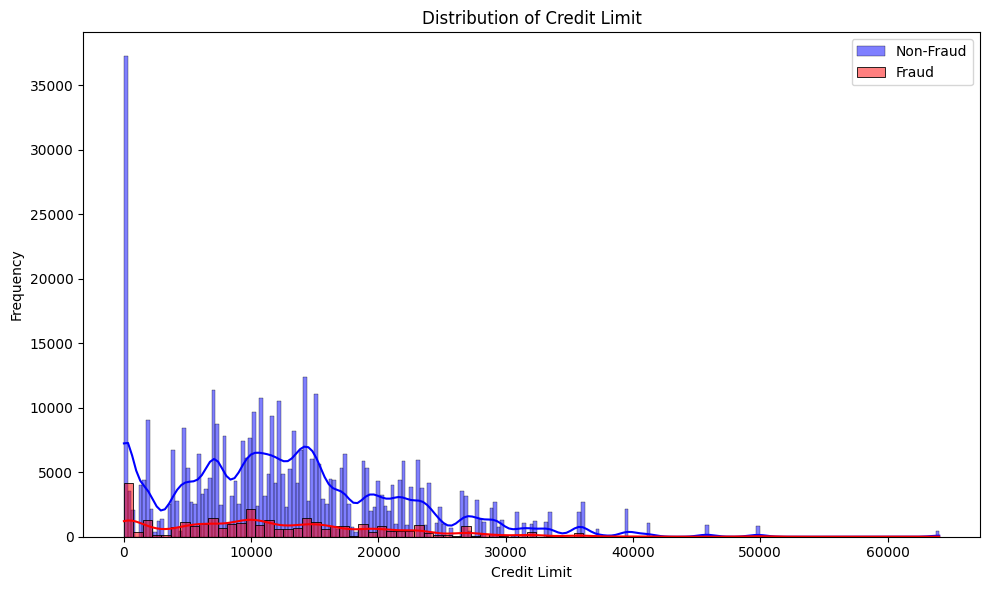

In [45]:
# Create a figure and axis
plt.figure(figsize=(10, 6))

# Create histograms for Non-Fraud and Fraud transactions
sns.histplot(data=train[train["is_fraud?"] == 0], x="credit_limit", color="blue", label="Non-Fraud", kde=True)
sns.histplot(data=train[train["is_fraud?"] == 1], x="credit_limit", color="red", label="Fraud", kde=True)

# Set title and labels
plt.title("Distribution of Credit Limit")
plt.xlabel("Credit Limit")
plt.ylabel("Frequency")

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

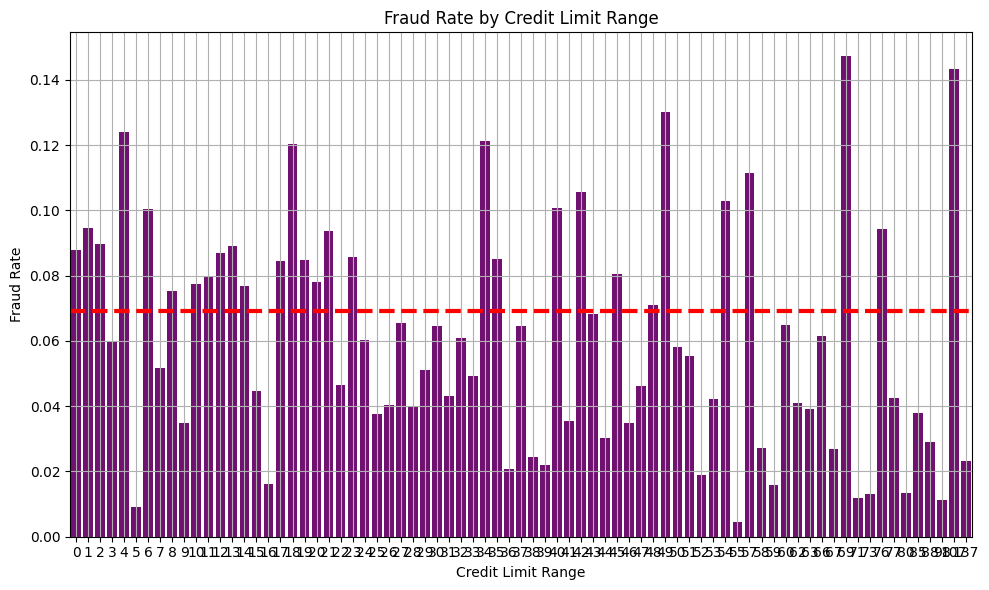

In [46]:
# Bin credit_limit using logarithmic bins
train["credit_limit_map"], bins = pd.cut(
    x=train["credit_limit"],
    bins=int(1 + np.log(2 * len(train)) * 10),
    labels=False,
    retbins=True
)

# Calculate the fraud rate by credit_limit_map
fraud_rate_by_limit = train.groupby("credit_limit_map")["is_fraud?"].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_rate_by_limit.index, y=fraud_rate_by_limit.values, color="purple")

# Add a dashed red line indicating the overall fraud rate
plt.axhline(y=train["is_fraud?"].mean(), color='red', linestyle='dashed', linewidth=3)

# Set the title and labels
plt.title("Fraud Rate by Credit Limit Range")
plt.xlabel("Credit Limit Range")
plt.ylabel("Fraud Rate")

# Show grid lines
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

### acct_open_date

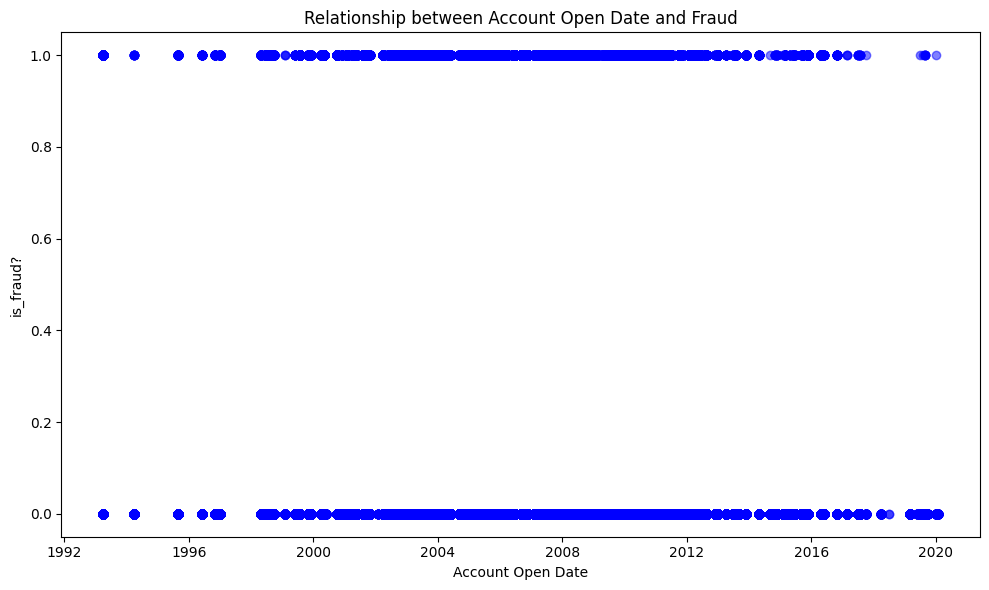

In [47]:
# Assuming train["acct_open_date"] is a string in "mm/yyyy" format
train["acct_open_date"] = pd.to_datetime(train["acct_open_date"], format="%m/%Y")

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(train["acct_open_date"], train["is_fraud?"], alpha=0.5, color="blue")

# Set the title and labels
plt.title("Relationship between Account Open Date and Fraud")
plt.xlabel("Account Open Date")
plt.ylabel("is_fraud?")

# Show the plot
plt.tight_layout()
plt.show()

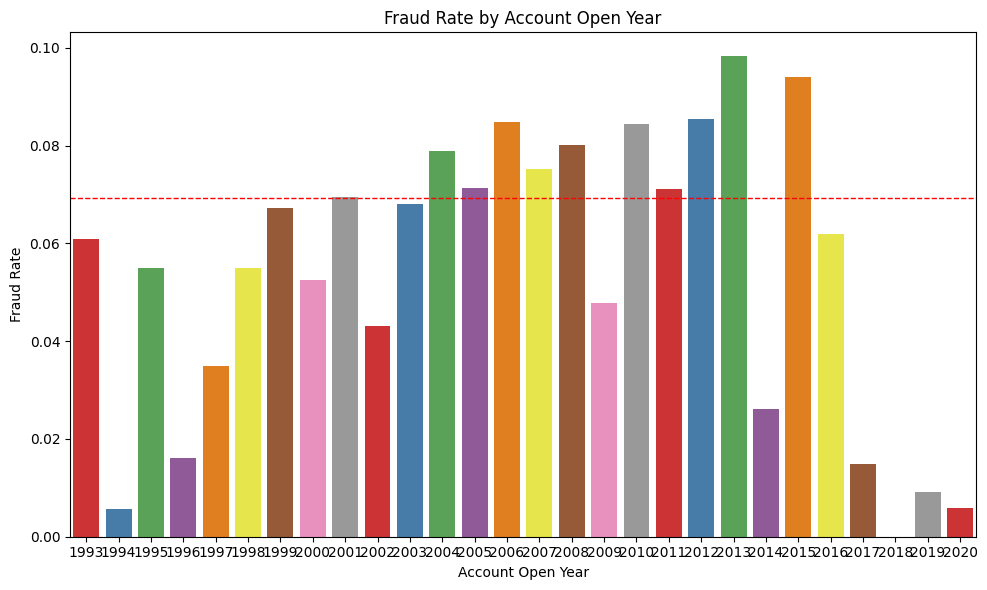

In [48]:
# Calculate the fraud rate by acct_open_date_year
fraud_rate_by_year = train.groupby("acct_open_date_2")["is_fraud?"].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_rate_by_year.index, y=fraud_rate_by_year.values, palette="Set1")

# Add a dashed red line indicating the overall fraud rate
plt.axhline(y=train["is_fraud?"].mean(), color='red', linestyle='dashed', linewidth=1)

# Set the title and labels
plt.title("Fraud Rate by Account Open Year")
plt.xlabel("Account Open Year")
plt.ylabel("Fraud Rate")

# Show the plot
plt.tight_layout()
plt.show()

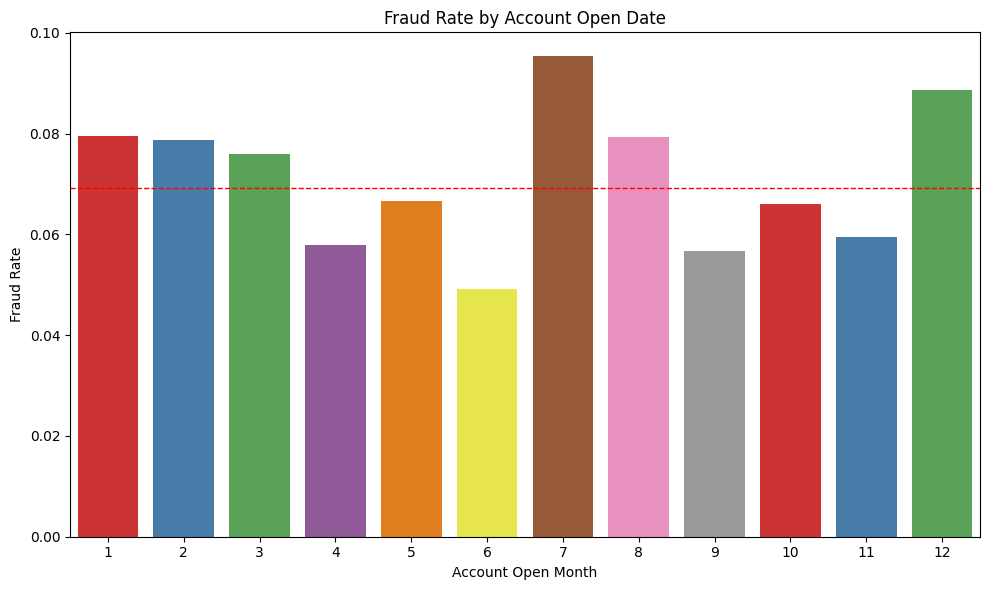

In [49]:
# Calculate the fraud rate by acct_open_date_year
fraud_rate_by_year = train.groupby("acct_open_date_1")["is_fraud?"].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_rate_by_year.index, y=fraud_rate_by_year.values, palette="Set1")

# Add a dashed red line indicating the overall fraud rate
plt.axhline(y=train["is_fraud?"].mean(), color='red', linestyle='dashed', linewidth=1)

# Set the title and labels
plt.title("Fraud Rate by Account Open Date")
plt.xlabel("Account Open Month")
plt.ylabel("Fraud Rate")

# Show the plot
plt.tight_layout()
plt.show()

### year_pin_last_changed

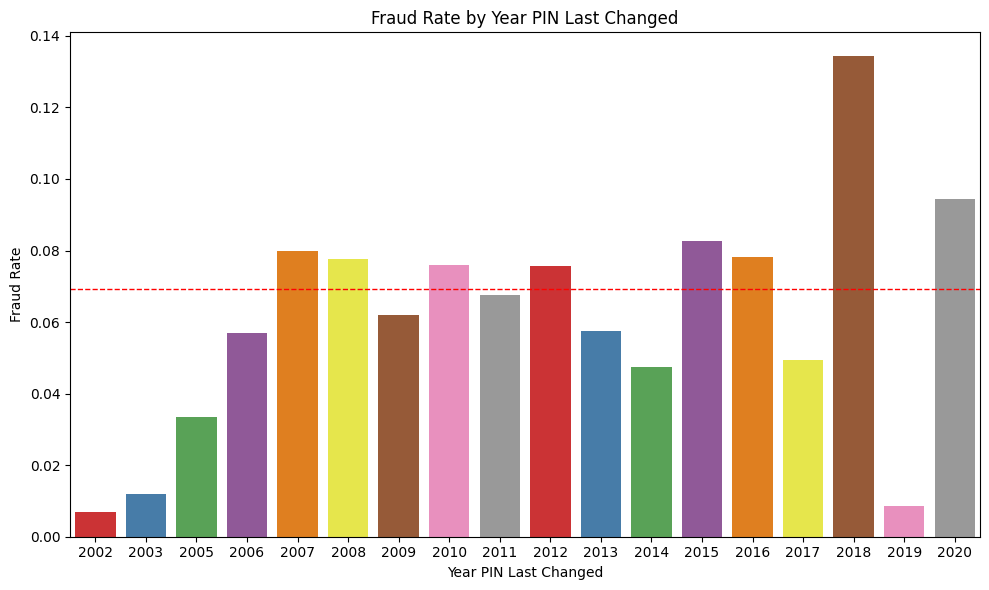

In [50]:
# Calculate the fraud rate by year_pin_last_changed
fraud_rate_by_year = train.groupby("year_pin_last_changed")["is_fraud?"].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_rate_by_year.index, y=fraud_rate_by_year.values, palette="Set1")

# Add a dashed red line indicating the overall fraud rate
plt.axhline(y=train["is_fraud?"].mean(), color='red', linestyle='dashed', linewidth=1)

# Set the title and labels
plt.title("Fraud Rate by Year PIN Last Changed")
plt.xlabel("Year PIN Last Changed")
plt.ylabel("Fraud Rate")

# Show the plot
plt.tight_layout()
plt.show()

### current_age

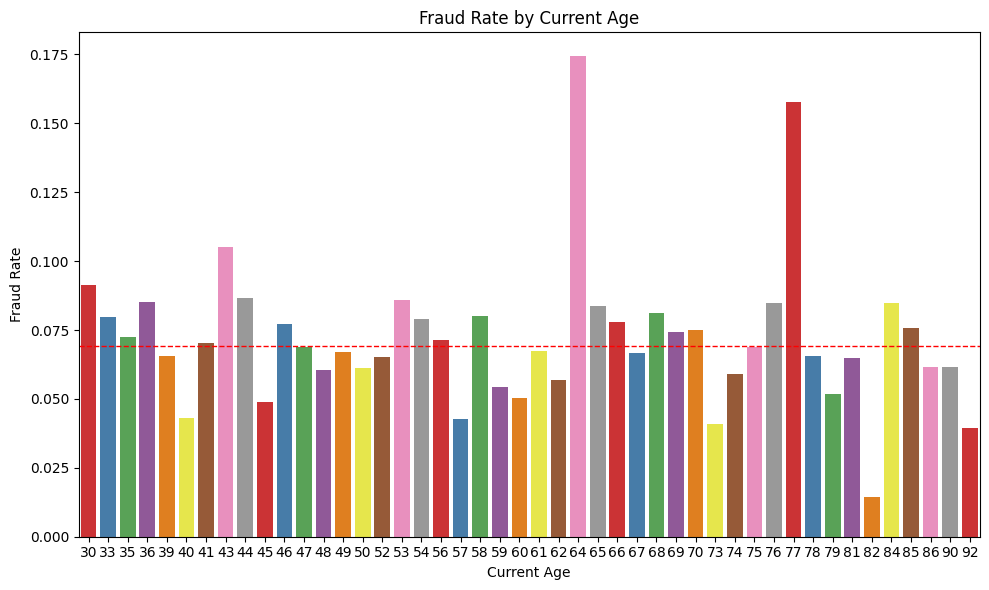

In [51]:

# Calculate the fraud rate by current_age
fraud_rate_by_age = train.groupby("current_age")["is_fraud?"].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_rate_by_age.index, y=fraud_rate_by_age.values, palette="Set1")

# Add a dashed red line indicating the overall fraud rate
plt.axhline(y=train["is_fraud?"].mean(), color='red', linestyle='dashed', linewidth=1)

# Set the title and labels
plt.title("Fraud Rate by Current Age")
plt.xlabel("Current Age")
plt.ylabel("Fraud Rate")

# Show the plot
plt.tight_layout()
plt.show()

### retirement_age

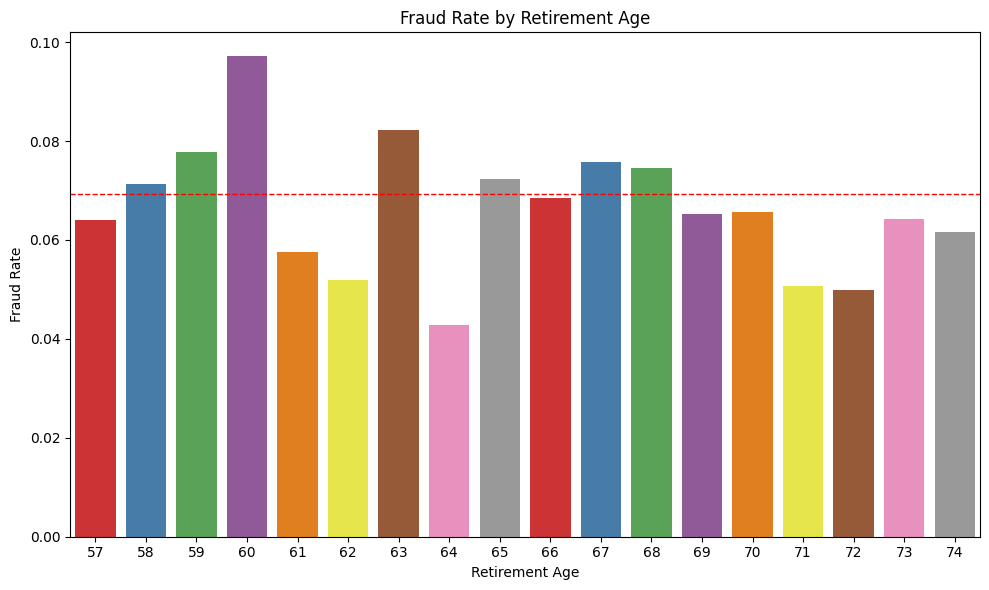

In [52]:
# Calculate the fraud rate by retirement_age
fraud_rate_by_retirement_age = train.groupby("retirement_age")["is_fraud?"].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_rate_by_retirement_age.index, y=fraud_rate_by_retirement_age.values, palette="Set1")

# Add a dashed red line indicating the overall fraud rate
plt.axhline(y=train["is_fraud?"].mean(), color='red', linestyle='dashed', linewidth=1)

# Set the title and labels
plt.title("Fraud Rate by Retirement Age")
plt.xlabel("Retirement Age")
plt.ylabel("Fraud Rate")

# Show the plot
plt.tight_layout()
plt.show()

### birth_year

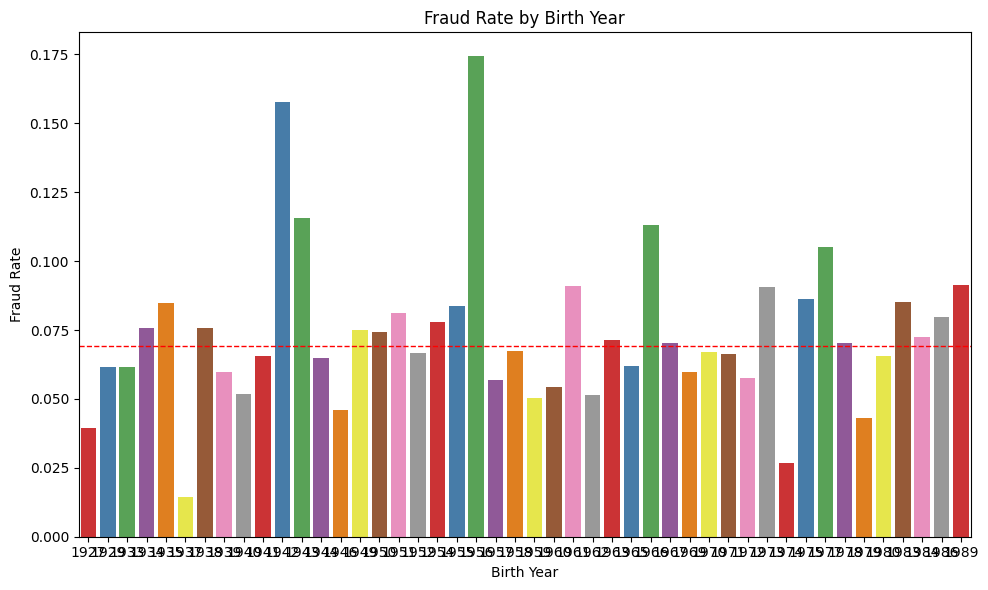

In [53]:
# Calculate the fraud rate by birth_year
fraud_rate_by_birth_year = train.groupby("birth_year")["is_fraud?"].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_rate_by_birth_year.index, y=fraud_rate_by_birth_year.values, palette="Set1")

# Add a dashed red line indicating the overall fraud rate
plt.axhline(y=train["is_fraud?"].mean(), color='red', linestyle='dashed', linewidth=1)

# Set the title and labels
plt.title("Fraud Rate by Birth Year")
plt.xlabel("Birth Year")
plt.ylabel("Fraud Rate")

# Show the plot
plt.tight_layout()
plt.show()

### birth_month

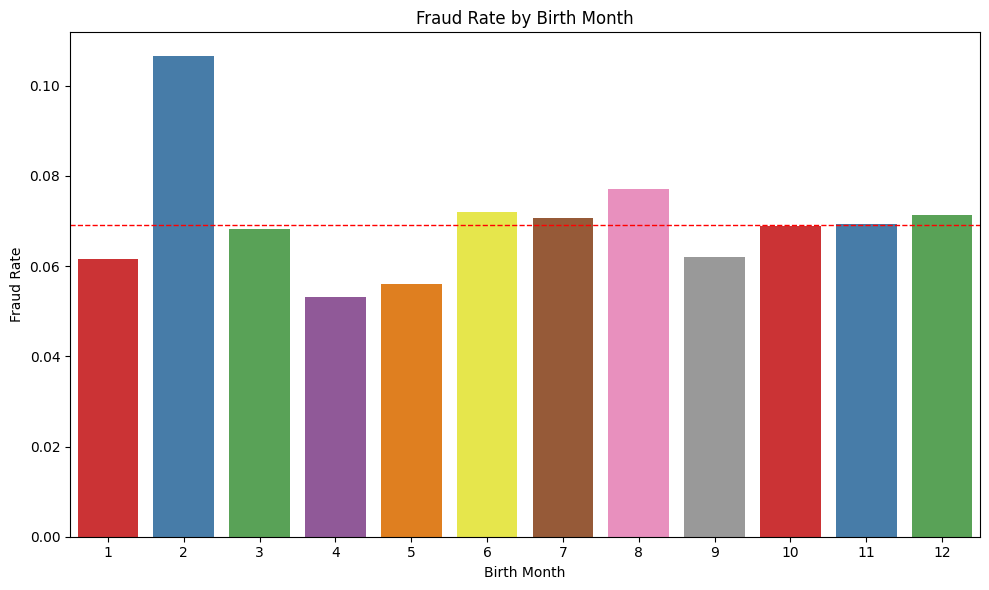

In [54]:
# Calculate the fraud rate by birth_month
fraud_rate_by_birth_month = train.groupby("birth_month")["is_fraud?"].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_rate_by_birth_month.index, y=fraud_rate_by_birth_month.values, palette="Set1")

# Add a dashed red line indicating the overall fraud rate
plt.axhline(y=train["is_fraud?"].mean(), color='red', linestyle='dashed', linewidth=1)

# Set the title and labels
plt.title("Fraud Rate by Birth Month")
plt.xlabel("Birth Month")
plt.ylabel("Fraud Rate")

# Show the plot
plt.tight_layout()
plt.show()

### gender

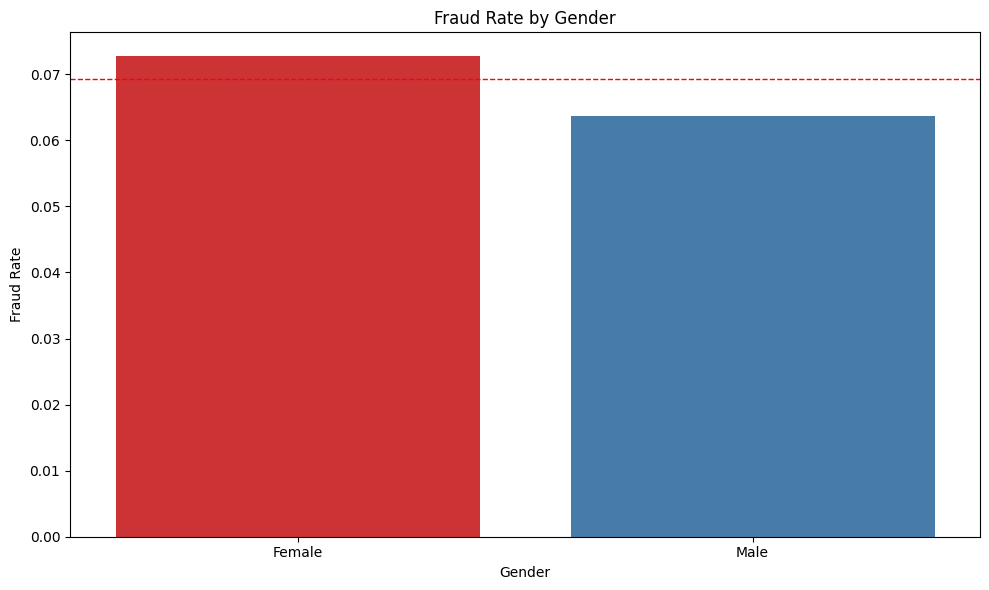

In [55]:
# Calculate the fraud rate by gender
fraud_rate_by_gender = train.groupby("gender")["is_fraud?"].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_rate_by_gender.index, y=fraud_rate_by_gender.values, palette="Set1")

# Add a dashed red line indicating the overall fraud rate
plt.axhline(y=train["is_fraud?"].mean(), color='red', linestyle='dashed', linewidth=1)

# Set the title and labels
plt.title("Fraud Rate by Gender")
plt.xlabel("Gender")
plt.ylabel("Fraud Rate")

# Show the plot
plt.tight_layout()
plt.show()

### address

In [56]:
train["address"]

0                    206 Pine Lane
1         8886 Little Creek Street
2                 273 Ocean Street
3                7276 Valley Drive
4                 5238 Park Street
                    ...           
471278          336 Catherine Lane
471279       9355 Ocean View Drive
471280        3550 Sixth Boulevard
471281           98086 Essex Drive
471282           98086 Essex Drive
Name: address, Length: 471283, dtype: object

In [57]:
train["street_name"] = train["address"].str.split(n=1).str[1]

この分割まずい？？  一部重複あり

In [58]:
len(train["street_name"].unique())

83

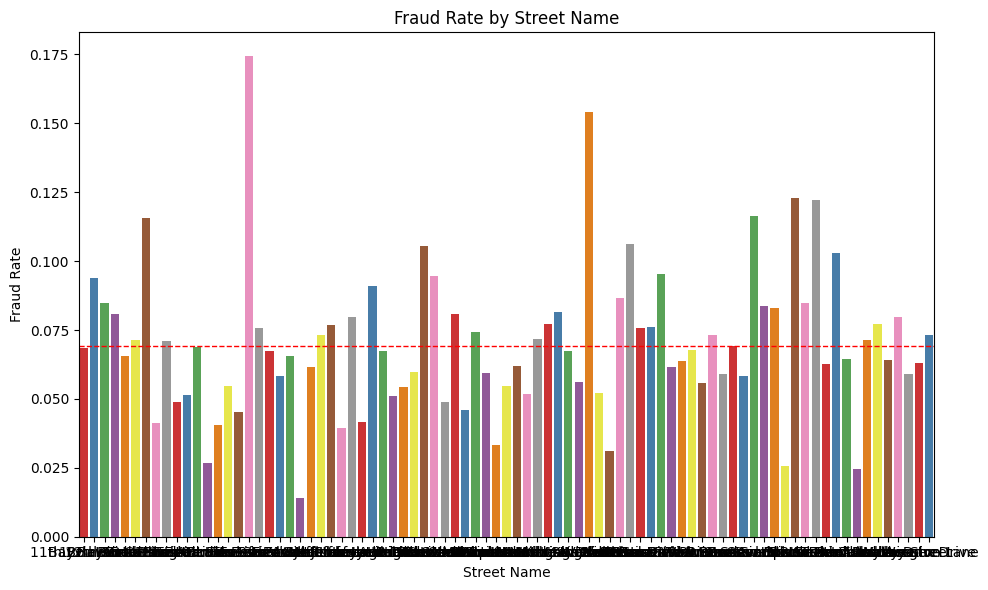

In [59]:

# Calculate the fraud rate by street_name
fraud_rate_by_street_name = train.groupby("street_name")["is_fraud?"].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_rate_by_street_name.index, y=fraud_rate_by_street_name.values, palette="Set1")

# Add a dashed red line indicating the overall fraud rate
plt.axhline(y=train["is_fraud?"].mean(), color='red', linestyle='dashed', linewidth=1)

# Set the title and labels
plt.title("Fraud Rate by Street Name")
plt.xlabel("Street Name")
plt.ylabel("Fraud Rate")

# Show the plot
plt.tight_layout()
plt.show()

>「番地」→「通り」→「建物名」→「市区町村」→「州の名前」→「郵便番号」

### per_capita_income_zipcode

In [60]:
train[train["per_capita_income_zipcode"] == 0]["zipcode"].unique()

array([76248, 10003], dtype=int64)

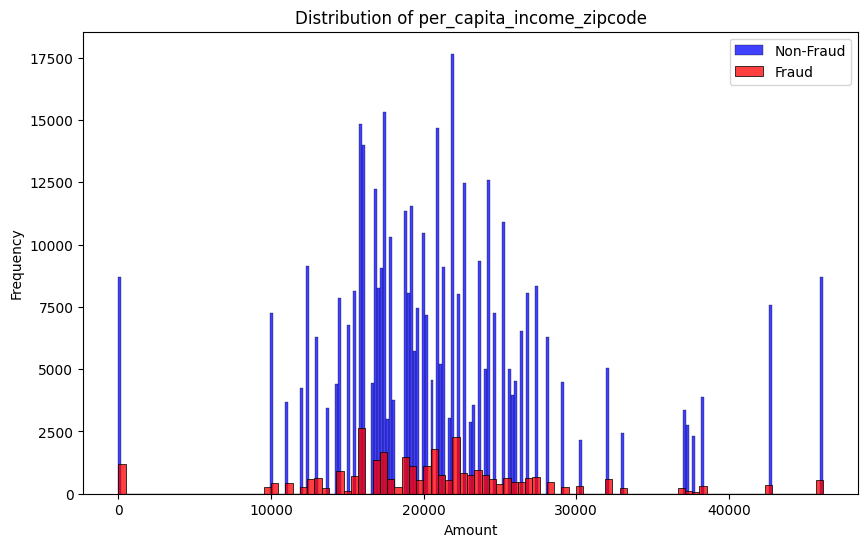

In [61]:
# グラフを作成
plt.figure(figsize=(10, 6))  # グラフのサイズを設定

# ヒストグラムを重ねてプロット
sns.histplot(data=train[train["is_fraud?"] == 0], x="per_capita_income_zipcode", color="blue", label="Non-Fraud")
sns.histplot(data=train[train["is_fraud?"] == 1], x="per_capita_income_zipcode", color="red", label="Fraud")


# グラフにタイトルとラベルを追加
plt.title("Distribution of per_capita_income_zipcode")
plt.xlabel("Amount")
plt.ylabel("Frequency")

# 凡例を表示
plt.legend()

# グラフを表示
plt.show()

### yearly_income_person

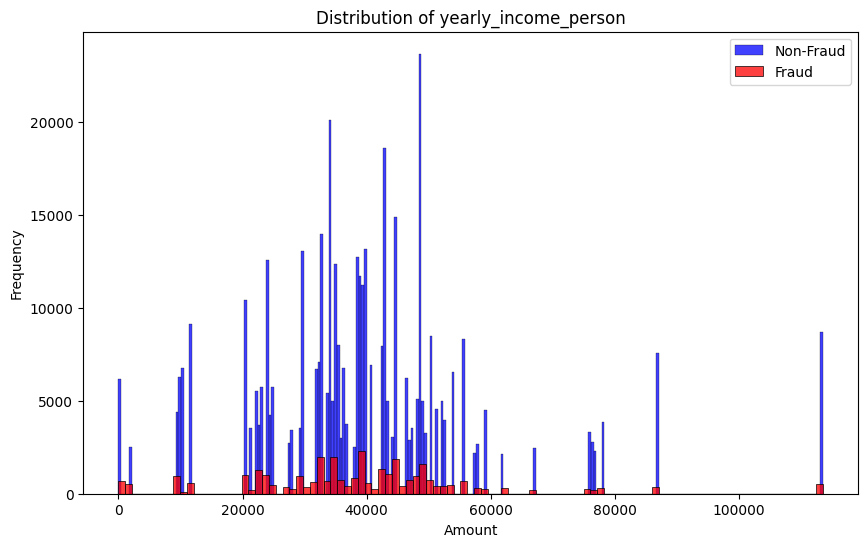

In [62]:
# グラフを作成
plt.figure(figsize=(10, 6))  # グラフのサイズを設定

# ヒストグラムを重ねてプロット
sns.histplot(data=train[train["is_fraud?"] == 0], x="yearly_income_person", color="blue", label="Non-Fraud")
sns.histplot(data=train[train["is_fraud?"] == 1], x="yearly_income_person", color="red", label="Fraud")


# グラフにタイトルとラベルを追加
plt.title("Distribution of yearly_income_person")
plt.xlabel("Amount")
plt.ylabel("Frequency")

# 凡例を表示
plt.legend()

# グラフを表示
plt.show()

In [63]:
train["yearly_income_person"].describe()

count    471283.000000
mean      39819.002188
std       18752.866339
min           1.000000
25%       29769.000000
50%       39003.000000
75%       48430.000000
max      113514.000000
Name: yearly_income_person, dtype: float64

1?

In [64]:
train[train["yearly_income_person"] == 0]

,index,user_id,card_id,amount,errors?,is_fraud?,merchant_id,merchant_city,merchant_state,zip,...,fico_score,num_credit_cards,expires_1,expires_2,acct_open_date_1,acct_open_date_2,amount_map,errors_map,credit_limit_map,street_name


### total_debt

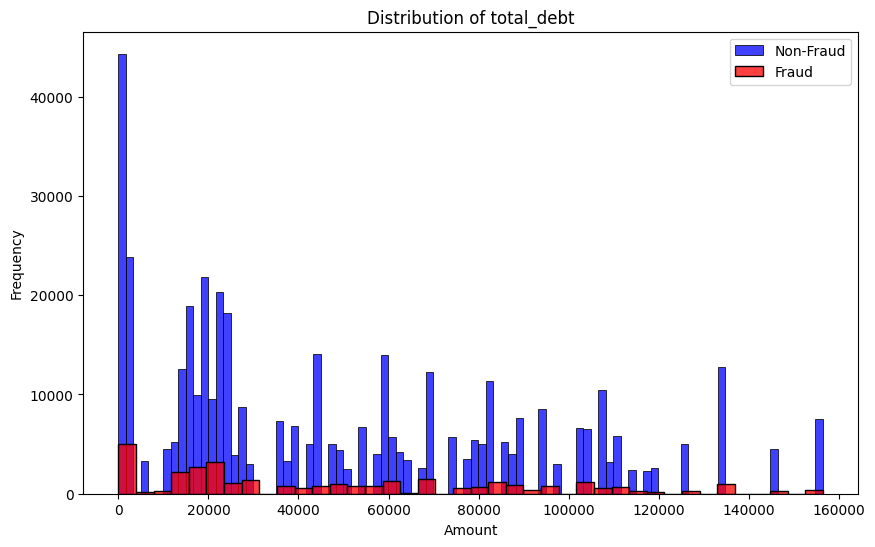

In [65]:
# グラフを作成
plt.figure(figsize=(10, 6))  # グラフのサイズを設定

# ヒストグラムを重ねてプロット
sns.histplot(data=train[train["is_fraud?"] == 0], x="total_debt", color="blue", label="Non-Fraud")
sns.histplot(data=train[train["is_fraud?"] == 1], x="total_debt", color="red", label="Fraud")


# グラフにタイトルとラベルを追加
plt.title("Distribution of total_debt")
plt.xlabel("Amount")
plt.ylabel("Frequency")

# 凡例を表示
plt.legend()

# グラフを表示
plt.show()

### fico_score

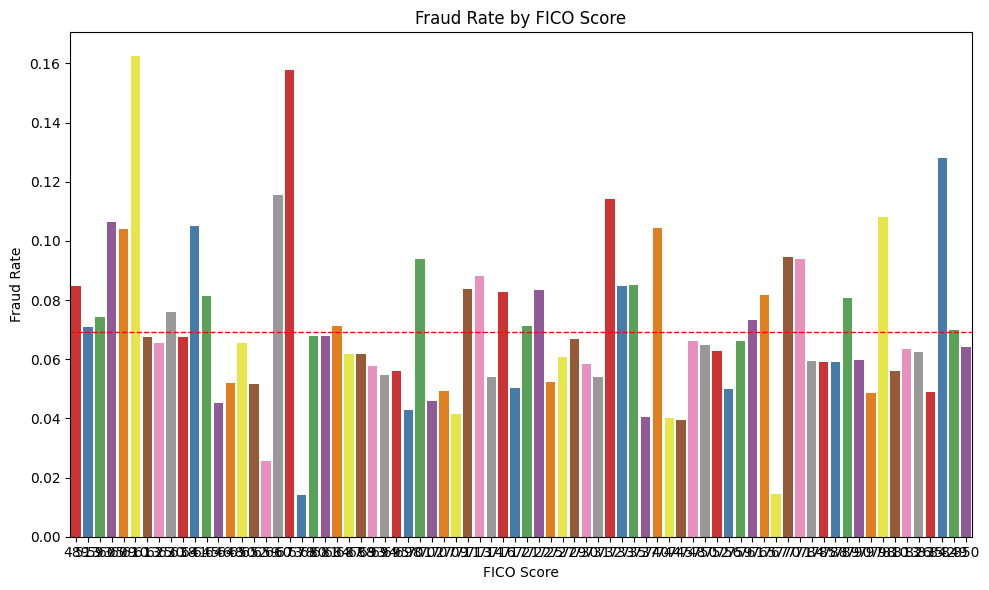

In [66]:

# Calculate the fraud rate by fico_score
fraud_rate_by_fico_score = train.groupby("fico_score")["is_fraud?"].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_rate_by_fico_score.index, y=fraud_rate_by_fico_score.values, palette="Set1")

# Add a dashed red line indicating the overall fraud rate
plt.axhline(y=train["is_fraud?"].mean(), color='red', linestyle='dashed', linewidth=1)

# Set the title and labels
plt.title("Fraud Rate by FICO Score")
plt.xlabel("FICO Score")
plt.ylabel("Fraud Rate")

# Show the plot
plt.tight_layout()
plt.show()

[クレジットスコア](https://manekai.ameba.jp/creditcard/21495100014869)

### num_credit_cards

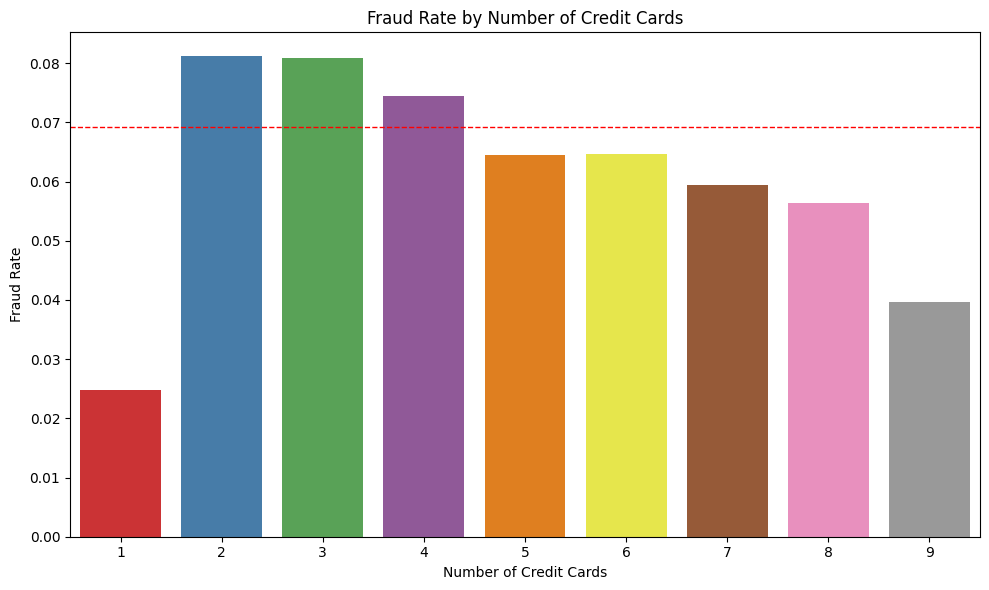

In [67]:
# Calculate the fraud rate by num_credit_cards
fraud_rate_by_num_credit_cards = train.groupby("num_credit_cards")["is_fraud?"].mean()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=fraud_rate_by_num_credit_cards.index, y=fraud_rate_by_num_credit_cards.values, palette="Set1")

# Add a dashed red line indicating the overall fraud rate
plt.axhline(y=train["is_fraud?"].mean(), color='red', linestyle='dashed', linewidth=1)

# Set the title and labels
plt.title("Fraud Rate by Number of Credit Cards")
plt.xlabel("Number of Credit Cards")
plt.ylabel("Fraud Rate")

# Show the plot
plt.tight_layout()
plt.show()

お！

'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'use_chip', 'flag', 'card_brand', 'card_type', 'expires', 'has_chip',
       'cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'current_age', 'retirement_age', 'birth_year',
       'birth_month', 'gender', 'address', 'city', 'state', 'zipcode',
       'latitude', 'longitude', 'per_capita_income_zipcode',
       'yearly_income_person', 'total_debt', 'fico_score', 'num_credit_cards',
       'expires_1', 'expires_2', 'acct_open_date_1', 'acct_open_date_2'